In [9]:
import pandas as pd
import numpy as np
import math
import pylab
import statsmodels.api as sm
import pandas_datareader
from statsmodels.regression.rolling import RollingOLS
from tabulate import tabulate
from pandas_datareader import data
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as si
import seaborn as sns
import sympy as sy
from sympy.stats import Normal, cdf
import urllib.request
import zipfile

Problem 2-----------------------------------------------------------------------------------------------------------------Problem 2

In [10]:
start_date = '2000-01-01'
end_date = '2020-12-31'
df1 = data.get_data_yahoo(['GS','IBM'], start = start_date, end = end_date)['Adj Close']
df1 = df1.pct_change().dropna()
dfMissing = df1['2019-01-01':'2020-01-01']
dfFill = df1[df1.index.min():end_date]
ols = sm.OLS(dfFill['GS'], dfFill['IBM']).fit()
beta = float(ols.params)
gsFill = dfMissing['IBM'] * beta
dfMerge = pd.concat([dfMissing, df1[start_date:'2001-01-01']])
ols2 = sm.OLS(dfFill['GS'], dfFill['IBM']).fit()
beta2 = float(ols.params)
gsFill = dfMissing['IBM'] * beta

In [11]:
def binary_search(arr, low, high, x):
    if high >= low:
        mid = (high + low) // 2
        if arr[mid] == x:
            return mid
        elif arr[mid] > x:
            return binary_search(arr, low, mid - 1, x)
        else:
            return binary_search(arr, mid + 1, high, x)
    else:
        return -1
# Test array
arr = [ 2, 3, 4, 10, 40 ]
x = 10
# Function call
result = binary_search(arr, 0, len(arr)-1, x)
if result != -1:
    print("Element is present at index", str(result))
else:
    print("Element is not present in array")

Element is present at index 3


Problem 2-----------------------------------------------------------------------------------------------------------------Problem 2

Problem 4-----------------------------------------------------------------------------------------------------------------Problem 4

In [12]:
# QUESTION 4 PART 3 Simulates stock paths based off of a monte carlo simulation process
# Can be set to an object so that it can be put into other processes
class monte_carlo_simulation:
    def __init__(self, S0, kappa, theta, t, r, sigma, n):
        # S0 = stock price 
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # m = number of simulations
        self.S0 = S0
        self.kappa = kappa
        self.theta = theta
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        
    def generate_simulated_stock_returns(self):
        # simulates the stock return values of a stock
        # goes directly to: generate_simulated_stock_values(self):
        mu = self.r
        returns = []
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            z = np.random.normal()
            stock_return = z * self.sigma * ((1 / self.n) ** 0.5)
            returns.append(stock_return)
        return np.array(returns)
    
    def generate_simulated_stock_values(self):
        # generates stock paths that can be used to value path dependant options
        stock_path = [self.S0]
        returns = self.generate_simulated_stock_returns()
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            #snext = stock_path[i] * np.exp(returns[i])
            #snext = stock_path[i] + returns[i]
            snext = stock_path[i] + (self.kappa * (self.theta - stock_path[i]) * ((1 / self.n) ** 0.5)) + returns[i]
            stock_path.append(snext)
        return np.array(stock_path)
    
    def plot_simulated_stock_values(self, num_trials = 1):
        # plots the simulation as a check to see if the paths look reasonable
        number_x = int(self.t * self.n//1)
        term_x = 1 / self.n
        x = 0
        list_for_x = [0]
        for i in range(number_x):
            x += term_x 
            list_for_x.append(x)
        for j in range(num_trials):
            list_y = self.generate_simulated_stock_values()
            plt.plot(list_for_x, list_y) 
        plt.title(f'{num_trials} simulated trials')
        plt.xlabel('years')
        plt.ylabel('$ value')
        return plt.show()

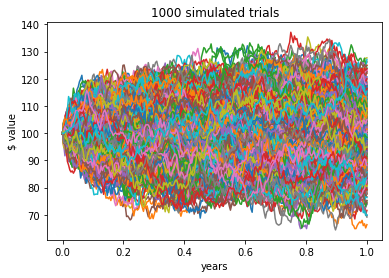

In [13]:
sim = monte_carlo_simulation(100, 0.2, 100, 1, 0, 25.0, 252)
sim.plot_simulated_stock_values(1000)

In [14]:
class MCStockOption(monte_carlo_simulation):

    def __init__(self, S0, K, B, kappa, theta, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # K = strike price
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # num_trials = number of simulations
        self.S0 = S0
        self.K = K
        self.B = B
        self.kappa = kappa
        self.theta = theta
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n
        self.num_trials = num_trials
        
    def __repr__(self):
        # prints a nicely formated object
        return f'MCStockOption (s=${self.S0:8.2f}, K={self.K:8.2f}, t={self.t:8.2f} (years), r={self.r:8.2f}, sigma={self.sigma:8.2f}, number of periods={self.n:8.2f}, num_trials={self.num_trials:8.2f}'

    def value(self):
        #will not actually perform anything, will get called in following classes
        if 'value' in dir(self):
            return self.value
        else:
            return 0
        
    def stderr(self):
        # computes a standard error
        if 'stdev' in dir(self):
            return self.stdev / math.sqrt(self.num_trials)
        return 0

In [15]:
class MCAmericanUpAndOut(MCStockOption):
    # class for a lookback put option
    def __init__(self, S0, K, B, kappa, theta, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # K = strike price
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # num_trials = number of simulations
        self.S0 = S0
        self.K = K
        self.B = B
        self.kappa = kappa
        self.theta = theta
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        self.num_trials = num_trials
        # s = initial 
        super().__init__(S0, K, B, kappa, theta, t, r, sigma, n, num_trials)
        
    def __repr__(self):
        # prints a nicely formated object
        return f'Up and Out American Call paramters, S0={self.S0}, K={self.K}, B={self.B}, Kappa={self.kappa}, theta={self.theta}, t={self.t}, r={self.r}, sigma={self.sigma}, number of periods={self.n}, num_trials={self.num_trials} '

    def value(self):
        
        lst_sx_UpAndOut = []
        for j in range(self.num_trials):
            sx_call = self.generate_simulated_stock_values()
            sp_call = sx_call
            sp_max = max(sp_call)
            #print(self.B)
            if sp_max < self.B:
                call_value = max(sp_max - self.K, 0) * np.exp(-self.r * self.t)
                lst_sx_UpAndOut.append(call_value)
            else:
                call_value = 0
                lst_sx_UpAndOut.append(call_value)
            #print(lst_sx_UpAndOut)
        self.mean = np.mean(lst_sx_UpAndOut)
        self.stdev = np.var(lst_sx_UpAndOut)
        
        return self.mean

In [16]:
UpAndOutCall = MCAmericanUpAndOut(100, 100, 108, 0.2, 100, 1, 0.0, 10.0, 252, 1000)
print(UpAndOutCall)
for i in range(8):
    count = 0
    UpAndOutCall_value = UpAndOutCall.value()
    print("Up-and-Out american call option : ", UpAndOutCall.value())
    count += i

Up and Out American Call paramters, S0=100, K=100, B=108, Kappa=0.2, theta=100, t=1, r=0.0, sigma=10.0, number of periods=252, num_trials=1000 
Up-and-Out american call option :  3.5559531926404326
Up-and-Out american call option :  3.6851719269024206
Up-and-Out american call option :  3.52688836943343
Up-and-Out american call option :  3.74604485046754
Up-and-Out american call option :  3.7476603194426805
Up-and-Out american call option :  3.775684193712721
Up-and-Out american call option :  3.6464383766423016
Up-and-Out american call option :  3.6566070656577874


Problem 4-----------------------------------------------------------------------------------------------------------------Problem 4

In [19]:
def fibonacci(n):
   if n <= 1:
       return n
   else:
       return(fibonacci(n-1) + fibonacci(n-2))
nterms = 15
if nterms <= 0:
   print("Plese enter a positive integer")
else:
   print("Fibonacci sequence:")
   for i in range(nterms):
       print(fibonacci(i))

Fibonacci sequence:
0
1
1
2
3
5
8
13
21
34
55
89
144
233
377


Problem 6-----------------------------------------------------------------------------------------------------------------Problem 6

In [20]:
class StochasticProcess:
    
    def __init__(self, S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # K = strike price
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # num_trials = number of simulations
        self.S0 = S0
        self.Process = Process
        self.OptionFlavor = OptionFlavor
        self.OptionType = OptionType
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        self.num_trials = num_trials
        #super().__init__(S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials)
        
    def __repr__(self):
        # prints a nicely formated object
        return f'MCStockOption (s=${self.S0:8.2f}, K={self.K:8.2f}, t={self.t:8.2f} (years), r={self.r:8.2f}, sigma={self.sigma:8.2f}, number of periods={self.n:8.2f}, num_trials={self.num_trials:8.2f}'

    def paths(self):
        #will not actually perform anything, will get called in following classes
        if self.Process == 'Bachelier':
            if 'BachelierPaths' in dir(self):
                return self.BachelierPaths()
            else:
                return 0
        else:
            if 'BlackScholesPaths' in dir(self):
                return self.BlackScholesPaths
            else:
                return 0

In [21]:
class Bachelier(StochasticProcess):
    def __init__(self, S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # m = number of simulations
        self.S0 = S0
        self.Process = Process
        self.OptionFlavor = OptionFlavor
        self.OptionType = OptionType
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        self.num_trials = num_trials
        super().__init__(S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials)
        
    def generate_simulated_stock_returns(self):
        # simulates the stock return values of a stock
        # goes directly to: generate_simulated_stock_values(self):
        mu = self.r
        returns = []
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            z = np.random.normal()
            #stock_return = (mu - (self.sigma ** 2) / 2) * (1 / self.n) + z * self.sigma * ((1 / self.n) ** 0.5)
            stock_return = z * self.sigma * ((1 / self.n) ** 0.5)
            returns.append(stock_return)
        return np.array(returns)
    
    def BachelierPaths(self):
        # generates stock paths that can be used to value path dependant options
        stock_path = [self.S0]
        returns = self.generate_simulated_stock_returns()
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            #snext = stock_path[i] * np.exp(returns[i])
            snext = stock_path[i] + returns[i]
            stock_path.append(snext)
        return np.array(stock_path)
    
    def plot_simulated_stock_values(self, num_trials = 1):
        # plots the simulation as a check to see if the paths look reasonable
        number_x = int(self.t * self.n//1)
        term_x = 1 / self.n
        x = 0
        list_for_x = [0]
        for i in range(number_x):
            x += term_x 
            list_for_x.append(x)
        for j in range(num_trials):
            list_y = self.BachelierPaths()
            plt.plot(list_for_x, list_y) 
        plt.title(f'{num_trials} simulated trials')
        plt.xlabel('years')
        plt.ylabel('$ value')
        return plt.show()

In [22]:
class BlackScholes(StochasticProcess):
    def __init__(self, S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # m = number of simulations
        self.S0 = S0
        self.Process = Process
        self.OptionFlavor = OptionFlavor
        self.OptionType = OptionType
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        self.num_trials = num_trials
        super().__init__(S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials)
        
    def generate_simulated_stock_returns(self):
        # simulates the stock return values of a stock
        # goes directly to: generate_simulated_stock_values(self):
        mu = self.r
        returns = []
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            z = np.random.normal()
            stock_return = (mu - (self.sigma ** 2) / 2) * (1 / self.n) + z * self.sigma * ((1 / self.n) ** 0.5)
            #stock_return = z * self.sigma * ((1 / self.n) ** 0.5)
            returns.append(stock_return)
        return np.array(returns)
    
    def BlackScholesPaths(self):
        # generates stock paths that can be used to value path dependant options
        stock_path = [self.S0]
        returns = self.generate_simulated_stock_returns()
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            snext = stock_path[i] * np.exp(returns[i])
            #snext = stock_path[i] + returns[i]
            stock_path.append(snext)
        return np.array(stock_path)
    
    def plot_simulated_stock_values(self, num_trials = 1):
        # plots the simulation as a check to see if the paths look reasonable
        number_x = int(self.t * self.n//1)
        term_x = 1 / self.n
        x = 0
        list_for_x = [0]
        for i in range(number_x):
            x += term_x 
            list_for_x.append(x)
        for j in range(num_trials):
            list_y = self.BlackScholesPaths()
            plt.plot(list_for_x, list_y) 
        plt.title(f'{num_trials} simulated trials')
        plt.xlabel('years')
        plt.ylabel('$ value')
        return plt.show()

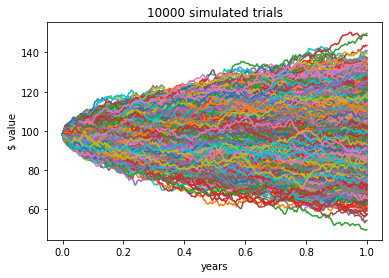

In [25]:
bachPath = Bachelier(98, 'Bachelier', 'Lookback', 'call', 100, 1, 0.0, 12, 252, 1000)
bachPath.plot_simulated_stock_values(10000)
#print(bachPath.BachelierPaths())

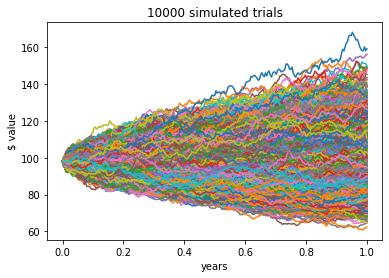

In [26]:
bsPath = BlackScholes(98, 'BlackScholes', 'European', 'put', 100, 1, 0.0, .12, 252, 1000)
bsPath.plot_simulated_stock_values(10000)

In [423]:
pathstring = BlackScholes(98, 'BlackScholes', 'European', 'put', 100, 1, 0.0, .12, 252, 100)
#print(pathstring.BlackScholesPaths())

In [424]:
class OptionPricer(StochasticProcess):

    def __init__(self, S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # m = number of simulations
        self.S0 = S0
        self.Process = Process
        self.OptionFlavor = OptionFlavor
        self.OptionType = OptionType
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        self.num_trials = num_trials
        
    def __repr__(self):
        # prints a nicely formated object
        return f'MCStockOption (s=${self.S0:8.2f}, K={self.K:8.2f}, t={self.t:8.2f} (years), r={self.r:8.2f}, sigma={self.sigma:8.2f}, number of periods={self.n:8.2f}, num_trials={self.num_trials:8.2f}'

    def price(self):
        
        if self.OptionFlavor == 'European':
        #will not actually perform anything, will get called in following classes
            if 'EuropeanPrice' in dir(self):
                return self.EuropeanPrice()
            else:
                return 0
        else:
            if 'LookbackPrice' in dir(self):
                return self.LookbackPrice()
            else:
                return 0
        
    def stderr(self):
        # computes a standard error
        if 'stdev' in dir(self):
            return self.stdev / math.sqrt(self.num_trials)
        return 0

In [425]:
class EuropeanOptionPricer(OptionPricer):

    def __init__(self, S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # m = number of simulations
        self.S0 = S0
        self.Process = Process
        self.OptionFlavor = OptionFlavor
        self.OptionType = OptionType
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        self.num_trials = num_trials
        super().__init__(S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials)
        
    def __repr__(self):
        # prints a nicely formated object
        return f'MC, MC_euro_put S0={self.S0}, K={self.K}, t={self.t}, r={self.r}, sigma={self.sigma}, number of periods={self.n}, num_trials={self.num_trials}'

    #def EuropeanCall(self):
    def EuropeanPrice(self):
        
        if self.Process == 'Bachelier':
            bachPath = Bachelier(98, 'Bachelier', 'Lookback', 'call', 100, 1, 0.0, 12, 252, 100)
            if self.OptionType == "call":
                lst_sx_call = []
                for j in range(self.num_trials):
                    sx_call = bachPath.BachelierPaths()
                    sp_call = sx_call[-1]
                    call_value = max(sp_call - self.K, 0) * np.exp(-self.r * self.t)
                    lst_sx_call.append(call_value)
            
                self.mean = np.mean(lst_sx_call)
                self.stdev = np.std(lst_sx_call)
        
                return self.mean
    
    #def EurpeanPut(self):
            else:
                lst_sx_put = []
                for i in range(self.num_trials):
                    sx_put = bachPath.BachelierPaths()
                    sp_put = sx_put[-1]
                    put_value = max(self.K - sp_put, 0) * np.exp(-self.r * self.t)
                    lst_sx_put.append(put_value)
            
                self.mean = np.mean(lst_sx_put)
                self.stdev = np.std(lst_sx_put)
        
                return self.mean
        else:
            bsPath = BlackScholes(98, 'BlackScholes', 'European', 'put', 100, 1, 0.0, .12, 252, 100)
            if self.OptionType == "call":
                lst_sx_call = []
                for j in range(self.num_trials):
                    sx_call = bsPath.BlackScholesPaths()
                    sp_call = sx_call[-1]
                    call_value = max(sp_call - self.K, 0) * np.exp(-self.r * self.t)
                    lst_sx_call.append(call_value)
            
                self.mean = np.mean(lst_sx_call)
                self.stdev = np.std(lst_sx_call)
        
                return self.mean
    
    #def EurpeanPut(self):
            else:
                lst_sx_put = []
                for i in range(self.num_trials):
                    sx_put = bsPath.BlackScholesPaths()
                    sp_put = sx_put[-1]
                    put_value = max(self.K - sp_put, 0) * np.exp(-self.r * self.t)
                    lst_sx_put.append(put_value)
            
                self.mean = np.mean(lst_sx_put)
                self.stdev = np.std(lst_sx_put)
        
                return self.mean
            

In [426]:
class LookBackPricer(OptionPricer):
    # class for a lookback put option
    def __init__(self, S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # m = number of simulations
        self.S0 = S0
        self.Process = Process
        self.OptionFlavor = OptionFlavor
        self.OptionType = OptionType
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        self.num_trials = num_trials
        super().__init__(S0, Process, OptionFlavor, OptionType, K, t, r, sigma, n, num_trials)
        
    def __repr__(self):
        # prints a nicely formated object
        return f'MCLookbackPutOption, S0={self.S0}, K={self.K}, t={self.t}, r={self.r}, sigma={self.sigma}, number of periods={self.n}, num_trials={self.num_trials}'

    #def LookbackCall(self):
        
    def LookbackPrice(self):
        
        if self.Process == 'Bachelier':
            bachPath = Bachelier(98, 'Bachelier', 'Lookback', 'call', 100, 1, 0.0, 12, 252, 100)
            if self.OptionType == "call":
                lst_sx_lookbackcall = []
                for j in range(self.num_trials):
                    sx_call = bachPath.BachelierPaths()
                    sp_call = sx_call
                    sp_max = max(sp_call)
                    call_value = max(sp_max - self.K, 0) * np.exp(-self.r * self.t)
                    lst_sx_lookbackcall.append(call_value)
            
                self.mean = np.mean(lst_sx_lookbackcall)
                self.stdev = np.std(lst_sx_lookbackcall)
        
                return self.mean
        
    #def LookbackPut(self):
            else:
            
                lst_sx_lookbackput = []
                for j in range(self.num_trials):
                    sx_call = bachPath.BachelierPaths()
                    sp_call = sx_call
                    sp_min = min(sp_call)
                    call_value = max(self.K - sp_min, 0) * np.exp(-self.r * self.t)
                    lst_sx_lookbackput.append(call_value)
            
                self.mean = np.mean(lst_sx_lookbackput)
                self.stdev = np.var(lst_sx_lookbackput)
        
                return self.mean
        else:
            bsPath = BlackScholes(98, 'BlackScholes', 'European', 'put', 100, 1, 0.0, .12, 252, 100)
            if self.OptionType == "call":
                lst_sx_lookbackcall = []
                for j in range(self.num_trials):
                    sx_call = bsPath.BlackScholesPaths()
                    sp_call = sx_call
                    sp_max = max(sp_call)
                    call_value = max(sp_max - self.K, 0) * np.exp(-self.r * self.t)
                    lst_sx_lookbackcall.append(call_value)
            
                self.mean = np.mean(lst_sx_lookbackcall)
                self.stdev = np.std(lst_sx_lookbackcall)
        
                return self.mean
        
    #def LookbackPut(self):
            else:
            
                lst_sx_lookbackput = []
                for j in range(self.num_trials):
                    sx_call = bsPath.BlackScholesPaths()
                    sp_call = sx_call
                    sp_min = min(sp_call)
                    call_value = max(self.K - sp_min, 0) * np.exp(-self.r * self.t)
                    lst_sx_lookbackput.append(call_value)
            
                self.mean = np.mean(lst_sx_lookbackput)
                self.stdev = np.var(lst_sx_lookbackput)
        
                return self.mean

In [427]:
optionprice1 = EuropeanOptionPricer(100, 'Bachelier', 'European', 'call', 100, 1, 0.0, 12, 252, 1000)
print(optionprice1.EuropeanPrice())

4.167806646431854


In [428]:
optionprice2 = EuropeanOptionPricer(100, 'Bachelier', 'European', 'put', 100, 1, 0.0, 12, 252, 1000)
print(optionprice2.EuropeanPrice())

5.6196513014625795


In [429]:
optionprice3 = EuropeanOptionPricer(100, 'BlackScholes', 'European', 'put', 100, 1, 0.0, .12, 252, 1000)
print(optionprice3.EuropeanPrice())

5.982384291456749


In [430]:
optionprice3 = EuropeanOptionPricer(100, 'BlackScholes', 'European', 'call', 100, 1, 0.0, .12, 252, 1000)
print(optionprice3.EuropeanPrice())

4.147502025383574


In [431]:
optionprice1 = LookBackPricer(100, 'Bachelier', 'Lookback', 'call', 100, 1, 0.0, 12, 252, 1000)
print(optionprice1.LookbackPrice())

7.418000196760609


In [432]:
optionprice1 = LookBackPricer(100, 'Bachelier', 'Lookback', 'put', 100, 1, 0.0, 12, 252, 1000)
print(optionprice1.LookbackPrice())

11.359680492267415


In [433]:
optionprice1 = LookBackPricer(100, 'BlackScholes', 'Lookback', 'put', 100, 1, 0.0, .12, 252, 1000)
print(optionprice1.LookbackPrice())

11.120938775153093


In [434]:
optionprice1 = LookBackPricer(100, 'BlackScholes', 'Lookback', 'call', 100, 1, 0.0, .12, 252, 1000)
print(optionprice1.LookbackPrice())

7.323257369027281
